In [40]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np


In [42]:
# Load dataset
df = pd.read_csv("Q1_dataset.csv")

# Feature matrix (true labels are NOT used for clustering)
X = df[['x1', 'x2']]

**K-Means** partitions the data into three clusters by iteratively assigning points to the nearest centroid and updating centroid positions to minimize within-cluster variance.

In [43]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X)

**GMM** models the data as a mixture of three Gaussian distributions and assigns each point to the cluster with the highest posterior probability.

In [44]:
gmm = GaussianMixture(n_components=3, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(X)

**DBSCAN** groups points based on local density, forming clusters where points are densely packed and labeling sparse points as noise (-1).

In [45]:
dbscan = DBSCAN(eps=0.6, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(X)

In [ ]:
df[['x1', 'x2', 'kmeans_cluster','gmm_cluster','dbscan_cluster']].head()

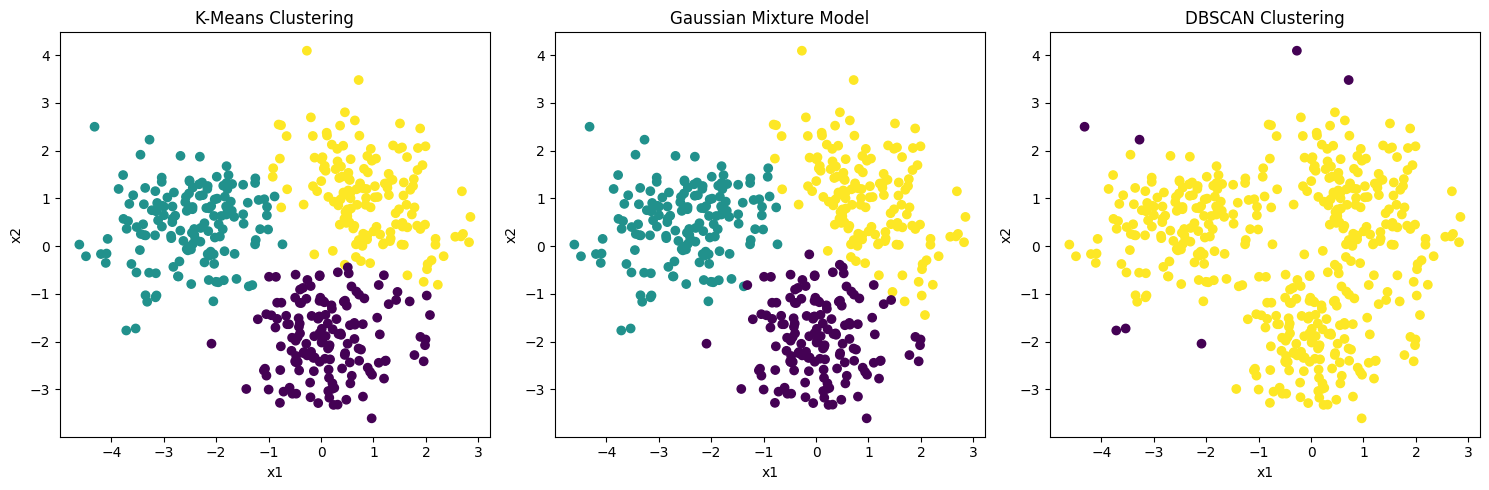

In [46]:

plt.figure(figsize=(15, 5))

# K-Means
plt.subplot(1, 3, 1)
plt.scatter(df['x1'], df['x2'], c=df['kmeans_cluster'])
plt.title("K-Means Clustering")
plt.xlabel("x1")
plt.ylabel("x2")

# GMM
plt.subplot(1, 3, 2)
plt.scatter(df['x1'], df['x2'], c=df['gmm_cluster'])
plt.title("Gaussian Mixture Model")
plt.xlabel("x1")
plt.ylabel("x2")

# DBSCAN
plt.subplot(1, 3, 3)
plt.scatter(df['x1'], df['x2'], c=df['dbscan_cluster'])
plt.title("DBSCAN Clustering")
plt.xlabel("x1")
plt.ylabel("x2")

# Ground Truth
# plt.subplot(2, 2, 4)
# plt.scatter(df['x1'], df['x2'], c=df['true_label'])
# plt.title("Ground Truth Clusters")
# plt.xlabel("x1")
# plt.ylabel("x2")

plt.tight_layout()
plt.show()

### Hyperparameter fine  tuning

In [ ]:
# Fine tuned K-Means


# Range of k values
K = range(2, 7)

inertia = []
silhouette_scores = {}

# Compute inertia and silhouette scores
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores[k] = silhouette_score(X, labels)

optimal_k = 3  # selected based on analysis

In [ ]:
# Create combined figure
plt.figure(figsize=(12, 5))

# Elbow plot
plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.axvline(x=optimal_k, linestyle='--', label=f'Optimal k = {optimal_k}')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for best k value")
plt.legend()

# Silhouette plot
plt.subplot(1, 2, 2)
plt.plot(
    list(silhouette_scores.keys()),
    list(silhouette_scores.values()),
    marker='o'
)
plt.axvline(x=optimal_k, linestyle='--', label=f'Optimal k = {optimal_k}')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Best k value")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
## Fine tuned GMM
bic_scores = {}

for cov in ['full', 'tied', 'diag', 'spherical']:
    for k in range(2, 7):
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=42)
        gmm.fit(X)
        bic_scores[(k, cov)] = gmm.bic(X)

best_config = min(bic_scores, key=bic_scores.get)
best_bic = bic_scores[best_config]

print(f"Best GMM configuration: n_components={best_config[0]}, "
      f"covariance_type='{best_config[1]}' with BIC={best_bic:.2f}")

In [ ]:
plt.figure()

for cov in ['full', 'tied', 'diag', 'spherical']:
    ks = [k for (k, c) in bic_scores if c == cov]
    bics = [bic_scores[(k, cov)] for k in ks]
    plt.plot(ks, bics, marker='o', label=cov)

plt.xlabel("Number of Components")
plt.ylabel("BIC Score")
plt.title("GMM BIC Scores for Different Covariance Types")
plt.legend()
plt.show()

In [ ]:
# Fine-tuned DBSCAN


results = []

for eps in [0.4, 0.5, 0.6, 0.7]:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X)

    # Exclude noise points
    mask = labels != -1
    unique_clusters = set(labels[mask])

    if len(unique_clusters) > 1:
        score = silhouette_score(X[mask], labels[mask])
    else:
        score = np.nan  # not valid

    results.append({
        "eps": eps,
        "num_clusters": len(unique_clusters),
        "num_noise_points": sum(labels == -1),
        "silhouette_score": score
    })

dbscan_results_df = pd.DataFrame(results)
dbscan_results_df


In [ ]:
plt.figure()
plt.plot(
    dbscan_results_df["eps"],
    dbscan_results_df["silhouette_score"],
    marker='o'
)
plt.xlabel("Epsilon (ε)")
plt.ylabel("Silhouette Score")
plt.title("DBSCAN Silhouette Score vs Epsilon")
plt.show()

## Comparing the selected algorithms on Silhouette Score, Davies–Bouldin, Calinski–Harabasz

In [35]:


X_np = X.values  # feature matrix

def evaluate_model(name, labels):
    labels = np.array(labels)

    # Handle DBSCAN noise (-1): exclude noise points
    mask = labels != -1
    X_eval = X_np[mask]
    labels_eval = labels[mask]

    # Metrics require at least 2 clusters
    if len(set(labels_eval)) < 2:
        return {
            "Algorithm": name,
            "Silhouette Score": np.nan,
            "Davies–Bouldin Index": np.nan,
            "Calinski–Harabasz Index": np.nan
        }

    return {
        "Algorithm": name,
        "Silhouette Score": silhouette_score(X_eval, labels_eval),
        "Davies–Bouldin Index": davies_bouldin_score(X_eval, labels_eval),
        "Calinski–Harabasz Index": calinski_harabasz_score(X_eval, labels_eval)
    }

# Evaluate all algorithms
results = [
    evaluate_model("K-Means", df["kmeans_cluster"]),
    evaluate_model("GMM", df["gmm_cluster"]),
    evaluate_model("DBSCAN", df["dbscan_cluster"])
]

# Create comparison table
comparison_df = pd.DataFrame(results)

# Optional: round values for presentation
comparison_df = comparison_df.round(4)

comparison_df


,Algorithm,Silhouette Score,Davies–Bouldin Index,Calinski–Harabasz Index
0,K-Means,0.5365,0.6306,660.9715
1,GMM,0.5337,0.6347,647.7046
2,DBSCAN,NaN,NaN,NaN


## Plotting a Clusted Data with Decision Region for each Algorithm

In [36]:


def plot_decision_regions(model, X, labels, title):
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:, 0], X[:, 1], c=labels)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")


C:\Users\Administrator\PycharmProjects\DataAnalyticsFinalExams\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


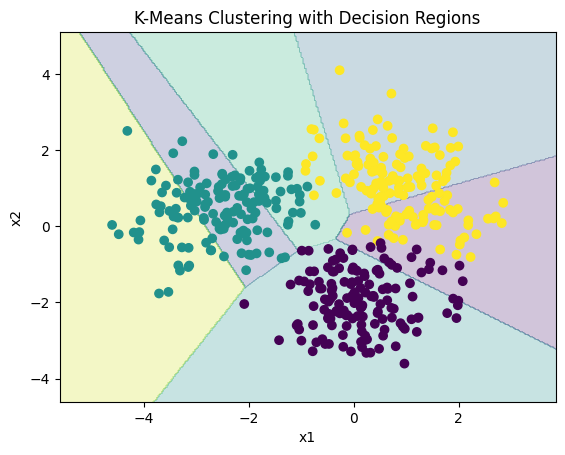

In [37]:
## Plot for K-Means Cluster Regions

plt.figure()
plot_decision_regions(
    kmeans,
    X.values,
    df["kmeans_cluster"].values,
    "K-Means Clustering with Decision Regions"
)
plt.show()


C:\Users\Administrator\PycharmProjects\DataAnalyticsFinalExams\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


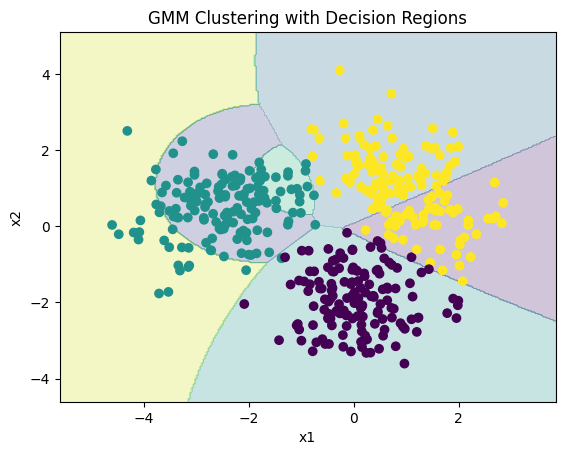

In [38]:
## Plot for GMM - Probablistic Cluster Regions
plt.figure()
plot_decision_regions(
    gmm,
    X.values,
    df["gmm_cluster"].values,
    "GMM Clustering with Decision Regions"
)
plt.show()


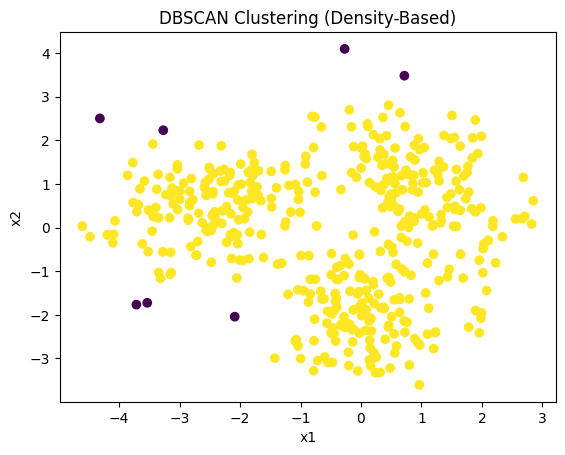

In [39]:
## Plot for DBSCAN

plt.figure()
plt.scatter(
    df["x1"],
    df["x2"],
    c=df["dbscan_cluster"]
)
plt.title("DBSCAN Clustering (Density-Based)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()
